# Juan Carlos Perez Ramirez
## Procesamiento de Lenguaje Natural
## Practica 3: DOR

In [2]:
import os
import re
from keras.preprocessing.text import Tokenizer

def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []

    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for tweet in f_corpus:
            tr_txt += [tweet]
        for label in f_truth:
            tr_y += [label]
    return tr_txt, tr_y

2025-02-23 01:51:48.218654: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 01:51:48.253328: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 01:51:48.253868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-23 01:51:48.921679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tr_txt, tr_y = get_texts_from_file("../../Corpus/mex20_train.txt", "../../Corpus/mex20_train_labels.txt")

In [4]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

In [5]:
import nltk 
# cuenta la frecuencia de aparicion de palabras y las almacena en un diccionario
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += tokenizer.tokenize(doc)

fdist = nltk.FreqDist(corpus_palabras)

In [6]:
# Ordena el diccionario de mayor a menor frecuencia
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [7]:
V = sortFreqDict(fdist)
V = V[:5000]

In [8]:
# se guarda en un diccionario debido a su rapido acceso
dict_indices = dict()
cont = 0

for weight, word in V:
    dict_indices[word] = cont
    cont += 1

# BoW

In [9]:
import numpy as np

# Construccion de la matriz de BOW, donde cada fila es un documento y cada columna una palabra donde se indica si esta presente o no
def build_bow_tr(tr_txt, V, dict_indices):
    BOW = np.zeros((len(tr_txt), len(V)),dtype=int)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices: # en caso de que la palabra no este en el diccionario recortado
                BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
        cont_doc += 1
    return BOW

In [10]:
BOW_tr = build_bow_tr(tr_txt, V, dict_indices)

# Compute DOR

In [11]:
from math import log10
def compute_dor(TR):
    TR_subset_in = TR # para filtrar el numero de documentos usados en la representacion de los terminos (agregar filtrado deseado, puede ser una muestra aleatoria de los documentos)

    DTR = np.zeros((TR_subset_in.shape[1], TR_subset_in.shape[0]), dtype=np.float64)
    print("DOR: Shape of the input matrix (BoT): ", TR.shape)
    print("DOR: Shape of the term-feat matrix: ", DTR.shape)

    tam_V = TR_subset_in.shape[1] # tamano del vocabulario total
    for i, doc in enumerate(TR_subset_in):
        nonzero_positions = np.nonzero(doc)[0]
        tam_v = len(nonzero_positions) # tamano del vocabulario del documento
        for term in nonzero_positions:
            DTR[term, i] = (1 + log10(doc[term])) * log10(tam_V/tam_v)
    return DTR

In [12]:
from sklearn import preprocessing
DOR_base = compute_dor(BOW_tr)
DOR_base = preprocessing.normalize(DOR_base, norm='l2')
DOR_base

DOR: Shape of the input matrix (BoT):  (5278, 5000)
DOR: Shape of the term-feat matrix:  (5000, 5278)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.0252718 ,
        0.01987597],
       [0.02323284, 0.        , 0.02078535, ..., 0.02197829, 0.        ,
        0.01965999],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [13]:
from sklearn.feature_selection import SelectKBest, chi2

feats = SelectKBest(chi2, k=1000) # seleccion de las 1000 mejores caracteristicas
feats.fit(BOW_tr, tr_y) # se ajusta para los terminos mas relevantes

SelectKBest(k=1000, score_func=<function chi2 at 0x7d3e2e943490>)

Se reducira el numero de terminos en la DOR, no por frecuencia o ponderacion, sino por relevancia para el problema en particular

In [ ]:
best = feats.get_support(indices=True)

In [ ]:
dict_indice_invertido = {}
for w in dict_indices:
    dict_indice_invertido[dict_indices[w]] = w 

In [ ]:
t_words = [dict_indice_invertido[index] for index in best]

In [ ]:
best

array([   0,    1,    2,    4,    5,    7,    9,   10,   11,   12,   13,
         17,   18,   19,   22,   24,   25,   28,   30,   32,   35,   36,
         37,   38,   39,   41,   43,   44,   47,   48,   49,   50,   51,
         53,   54,   56,   57,   58,   59,   61,   63,   64,   65,   66,
         67,   69,   70,   71,   74,   78,   79,   85,   86,   87,   88,
         89,   92,   93,   94,   97,  100,  102,  103,  104,  105,  107,
        108,  109,  110,  111,  114,  115,  116,  117,  118,  119,  120,
        122,  123,  124,  125,  128,  129,  131,  133,  134,  135,  136,
        140,  143,  147,  148,  150,  151,  153,  154,  155,  157,  160,
        162,  163,  164,  166,  167,  170,  177,  178,  179,  181,  182,
        184,  185,  186,  187,  188,  191,  192,  193,  200,  201,  207,
        209,  211,  216,  217,  221,  222,  225,  230,  231,  233,  235,
        236,  237,  239,  240,  243,  245,  246,  248,  249,  250,  252,
        253,  256,  257,  258,  259,  260,  264,  2

In [ ]:
target_matrix = DOR_base[best,:] # se filtran los renglones de la DOR que corresponden a los terminos seleccionados
target_matrix.shape

(1000, 5278)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
reduced_matrix = tsne.fit_transform(target_matrix)

In [ ]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]

/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  func(*args, **kwargs)
/home/juancho/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128556 (\N{GRIMACIN

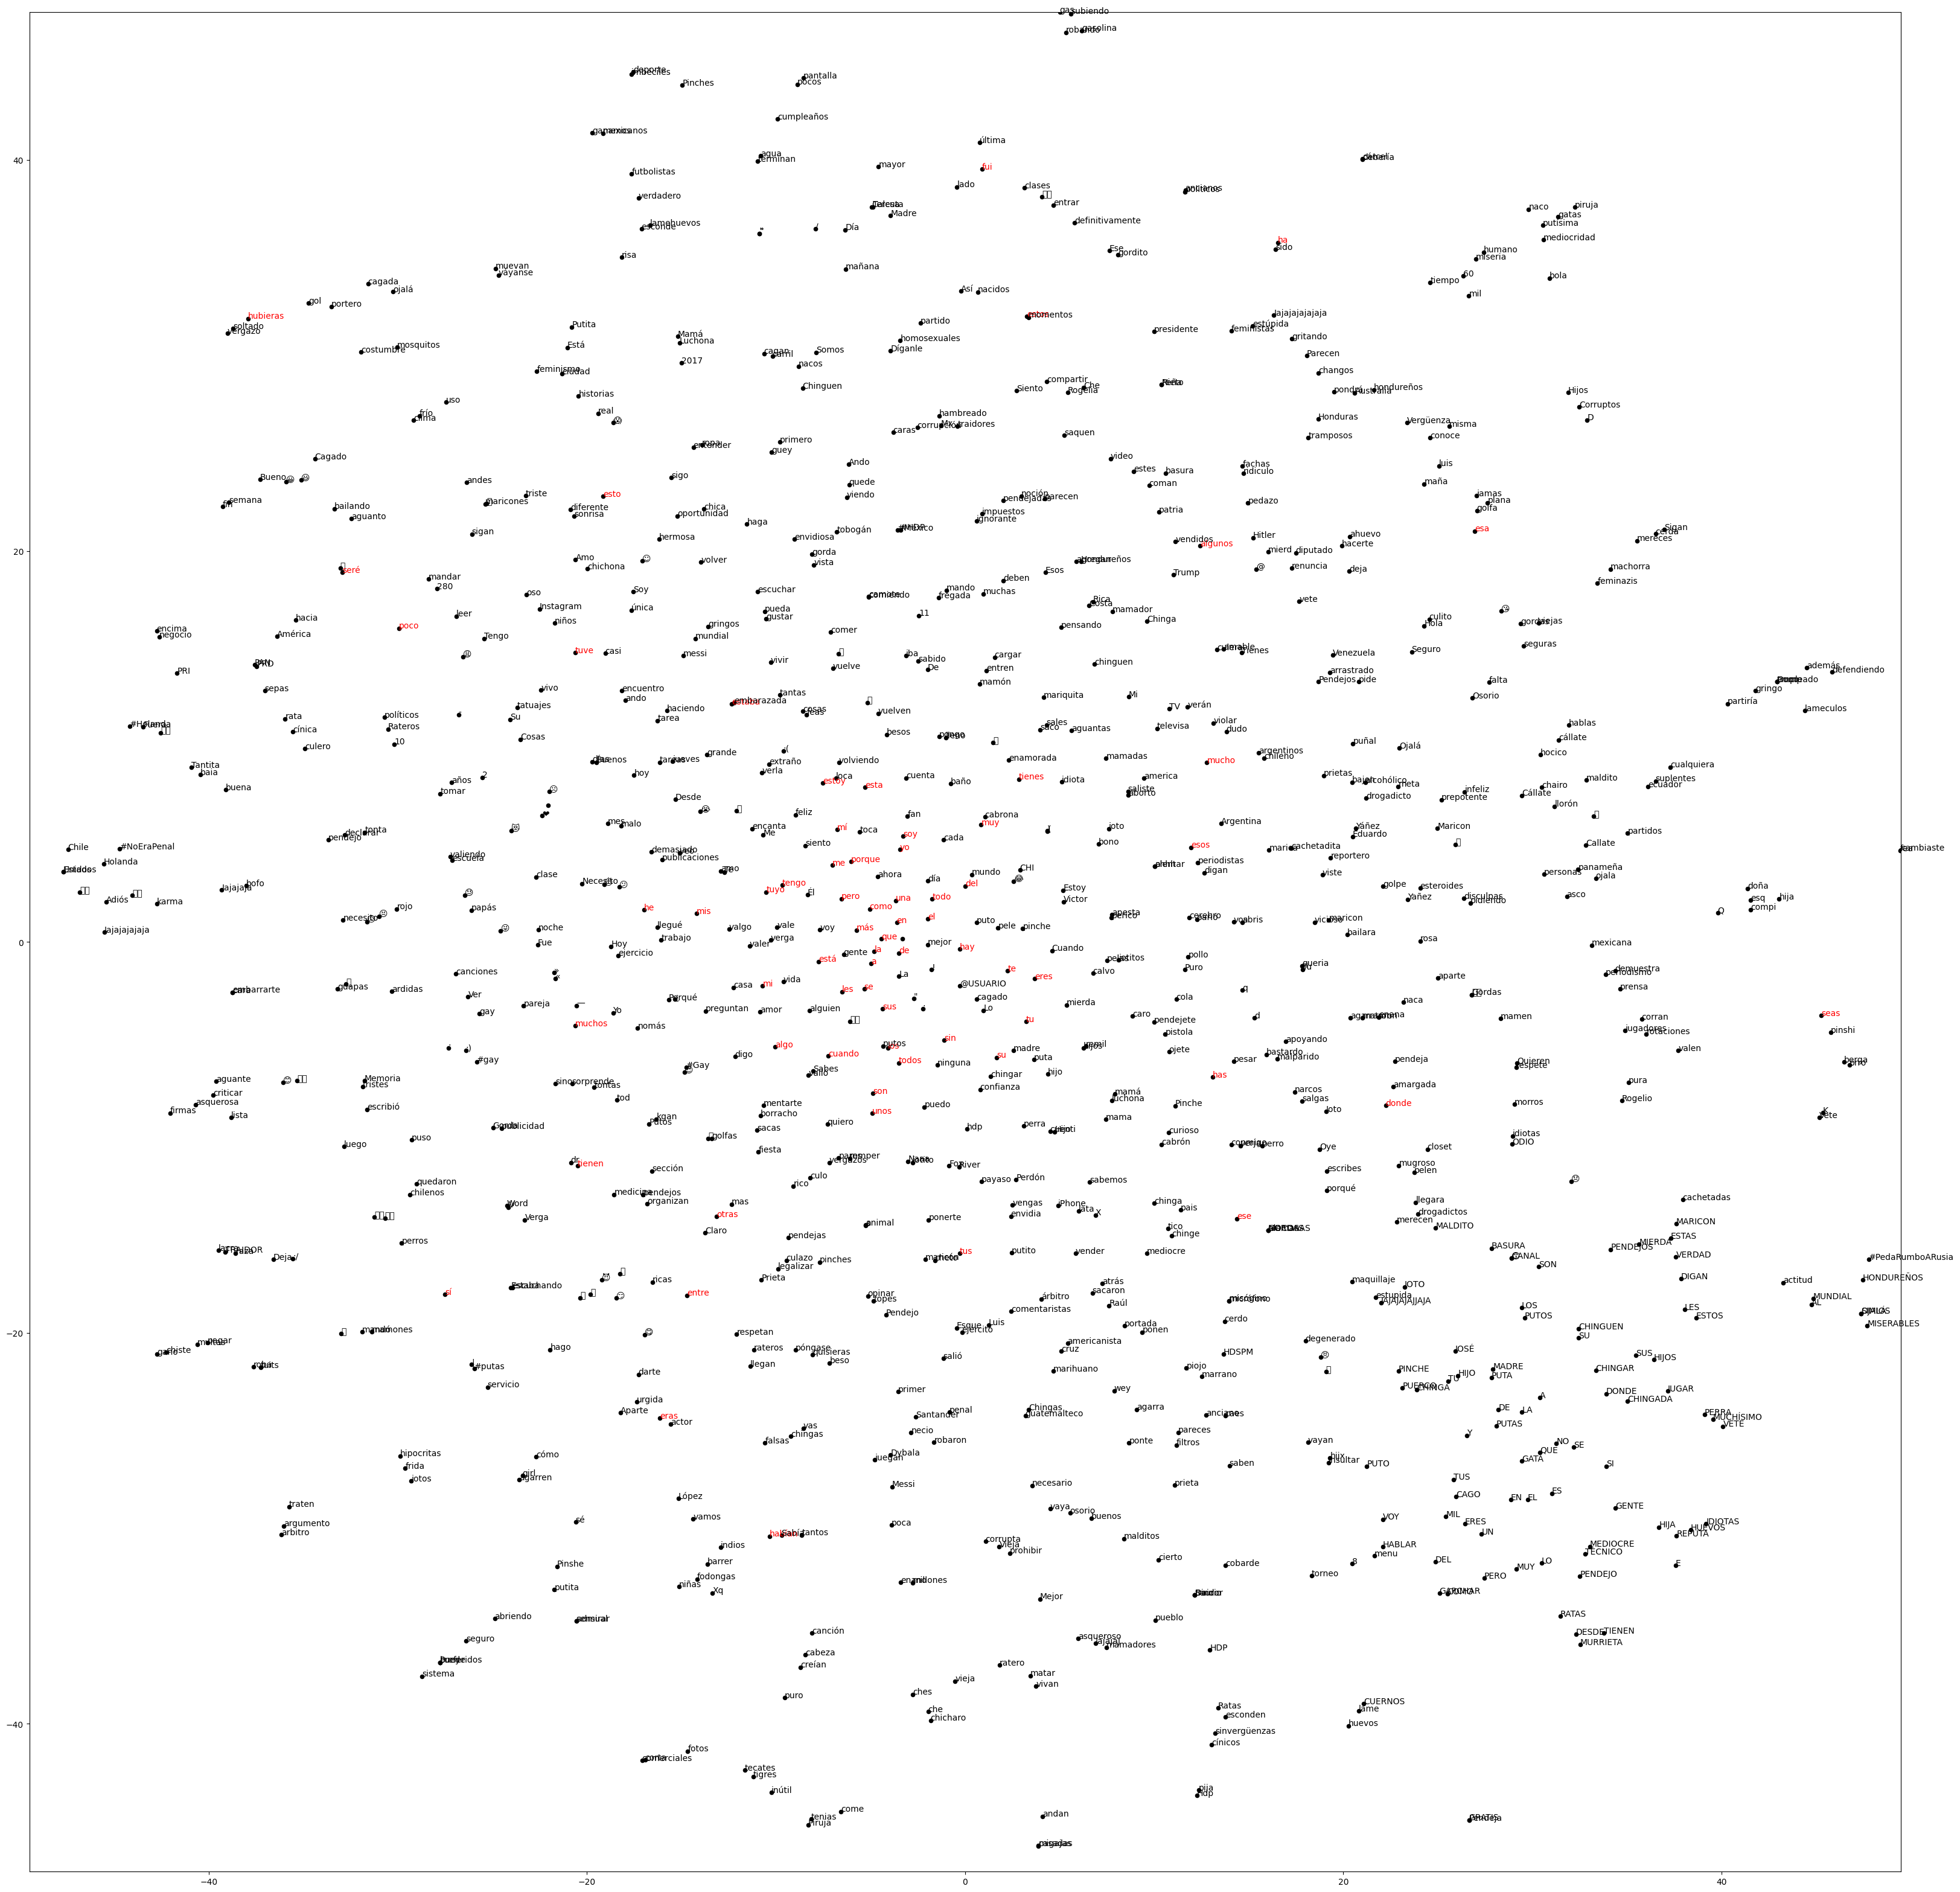

In [ ]:
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
sw = set(stopwords.words("spanish"))

plt.figure(figsize=(40,40), dpi=100); plt.xlim(-max_x, max_x); plt.ylim(-max_y, max_y)
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1], 20, color='k')

for idx, word in enumerate(t_words):
    x = reduced_matrix[idx,0]
    y = reduced_matrix[idx,1]
    if word in sw:
        plt.annotate(word, (x,y), color='r')
    else:
        plt.annotate(word, (x,y), color='k')


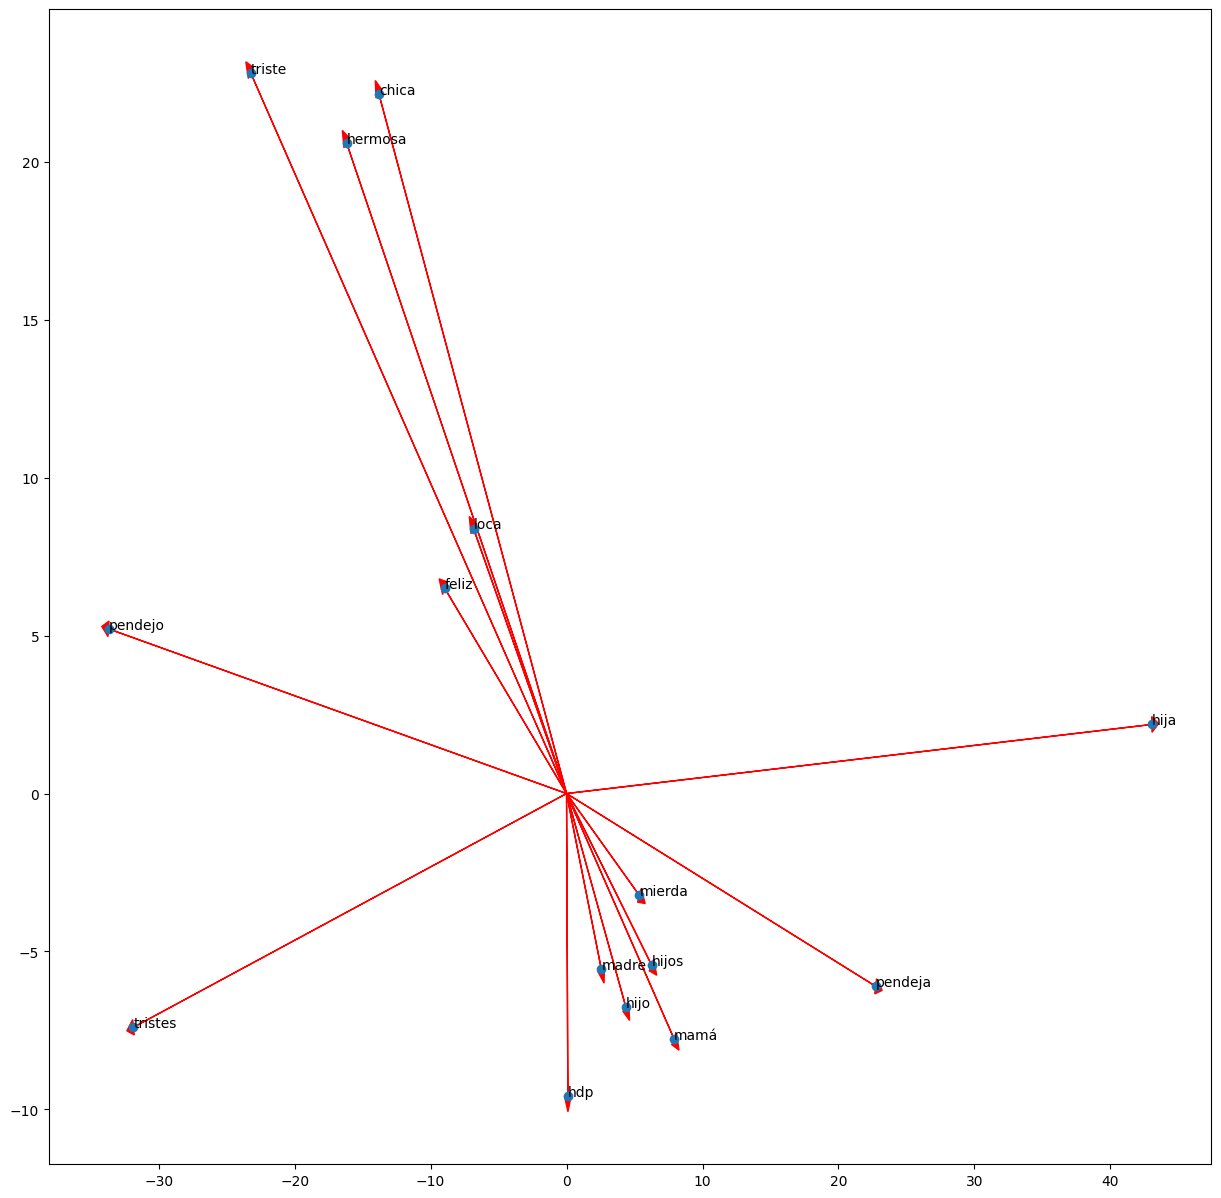

In [ ]:
subsetwords = ["tristes", "triste", "feliz", "hermosa", "chica", "hombres", "hdp", "madre", "madres", "@usuario", "hijos", "pendeja", "pendejo", "mierda", "loca", "hijo", "hija", "mamá", "tía"]

ploted_subsetwords = []
subreduced_matrix = []
for idx, word in enumerate(t_words):
    if word in subsetwords:
        ploted_subsetwords += [word]
        subreduced_matrix += [reduced_matrix[idx]]

subreduced_matrix = np.array(subreduced_matrix)

fig, ax = plt.subplots(figsize=(15,15))

col1 = 0
col2 = 1

for word in subreduced_matrix:
    ax.arrow(0, 0, word[col1], word[col2], head_width=0.5, head_length=0.5, fc='r', ec='r')

ax.scatter(subreduced_matrix[:,0], subreduced_matrix[:,1])

for i in range(len(ploted_subsetwords)):
    ax.annotate(ploted_subsetwords[i], (subreduced_matrix[i,col1], subreduced_matrix[i,col2]))

plt.show()